In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer


In [3]:
def read_data():
  X=pd.read_csv("/content/water_potability.csv")
  return X

In [4]:
def split_data(df):
  X_train, X_test, y_train, y_test = train_test_split(
    df.drop("Potability",axis=1),
    df['Potability'],
    test_size=0.3,
    random_state=0)
  return X_train, X_test, y_train, y_test

In [37]:
def bkp_df(X_train, X_test, y_train, y_test):
 X_train_t=X_train.copy()
 y_train_t=y_train.copy()
 X_test_t=X_test.copy()
 y_test_t=y_test.copy()
 X_train_t.reset_index(inplace=True, drop=True)
 y_train_t.reset_index(inplace=True, drop=True)
 X_test_t.reset_index(inplace=True, drop=True) 
 y_test_t.reset_index(inplace=True, drop=True)
 return X_train_t,y_train_t,X_test_t,y_test_t

In [6]:
 def initialize_imputers():
    imputer_bayes = IterativeImputer(
        estimator=BayesianRidge(),
        max_iter=10,
        random_state=0)

    imputer_knn = IterativeImputer(
        estimator=KNeighborsRegressor(n_neighbors=5),
        max_iter=10,
        random_state=0)

    imputer_nonLin = IterativeImputer(
        estimator=DecisionTreeRegressor(max_features='sqrt', random_state=0),
        max_iter=500,
        random_state=0)

    imputer_missForest = IterativeImputer(
        estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
        max_iter=100,
        random_state=0)
    return imputer_bayes,imputer_knn,imputer_nonLin,imputer_missForest

In [7]:
def fit_transform(df,type_model):
    if type_model=="Bayes":
        X_train_fit_bayes = imputer_bayes.fit_transform(df)
        X_train_fit_bayes = pd.DataFrame(X_train_fit_bayes,columns=df.columns)
    return X_train_fit_bayes

In [8]:
def comp_dist(df_chnaged,df_orig,col):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    df_orig[col].plot(kind='kde', ax=ax, color='blue')
    df_chnaged[col].plot(kind='kde', ax=ax, color='Green')
    lines, labels = ax.get_legend_handles_labels()
    labels = ['ph Original', 'ph Imputed']
    ax.legend(lines, labels, loc='best')
    plt.title('Variable A3 distribution after MICE')
    plt.show()

In [38]:
df_main=read_data()
df=df_main.copy()
X_train, X_test, y_train, y_test=split_data(df_main)
X_train_t,y_train_t,X_test_t,y_test_t=bkp_df(X_train, X_test, y_train, y_test)
#imputer_bayes,imputer_knn,imputer_nonLin,imputer_missForest=initialize_imputers()
#X_train_fit_bayes=fit_transform(X_train_t,"Bayes")


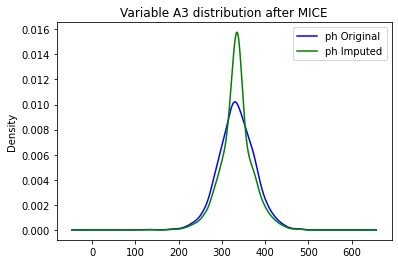

In [10]:
comp_dist(X_train_fit_bayes,X_train_t,'Sulfate')

In [54]:
pipe = Pipeline(steps=[
    ('imputer', IterativeImputer(
        estimator=BayesianRidge(),
        max_iter=10,
        random_state=0)),  
        ('regressor', Lasso(max_iter=2000))
])

param_grid = {
    'imputer__estimator__n_iter': [300,500,400],
    'imputer__estimator__alpha_1': [10, 100, 200],
    'regressor__alpha': [10, 100, 200],
}

In [55]:
grid_search = GridSearchCV(pipe,param_grid, cv=5, n_jobs=-1, scoring='r2')

In [56]:
#grid_search.fit(X_train_t,y_train_t)
pipe.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'imputer', 'regressor', 'imputer__add_indicator', 'imputer__estimator__alpha_1', 'imputer__estimator__alpha_2', 'imputer__estimator__alpha_init', 'imputer__estimator__compute_score', 'imputer__estimator__copy_X', 'imputer__estimator__fit_intercept', 'imputer__estimator__lambda_1', 'imputer__estimator__lambda_2', 'imputer__estimator__lambda_init', 'imputer__estimator__n_iter', 'imputer__estimator__normalize', 'imputer__estimator__tol', 'imputer__estimator__verbose', 'imputer__estimator', 'imputer__imputation_order', 'imputer__initial_strategy', 'imputer__max_iter', 'imputer__max_value', 'imputer__min_value', 'imputer__missing_values', 'imputer__n_nearest_features', 'imputer__random_state', 'imputer__sample_posterior', 'imputer__skip_complete', 'imputer__tol', 'imputer__verbose', 'regressor__alpha', 'regressor__copy_X', 'regressor__fit_intercept', 'regressor__max_iter', 'regressor__normalize', 'regressor__positive', 'regressor__precompute', 'regre

In [57]:
grid_search.fit(X_train_t,y_train_t)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        IterativeImputer(estimator=BayesianRidge(),
                                                         random_state=0)),
                                       ('regressor', Lasso(max_iter=2000))]),
             n_jobs=-1,
             param_grid={'imputer__estimator__alpha_1': [10, 100, 200],
                         'imputer__estimator__n_iter': [300, 500, 400],
                         'regressor__alpha': [10, 100, 200]},
             scoring='r2')

In [58]:
print(("best linear regression from grid search: %.3f"
       % grid_search.score(X_train_t, y_train_t)))

best linear regression from grid search: 0.002


In [59]:
# and finally let's check the performance over the test set
print(("best linear regression from grid search: %.3f"
       % grid_search.score(X_test_t, y_test_t)))

best linear regression from grid search: -0.003


In [60]:
grid_search.best_params_


{'imputer__estimator__alpha_1': 10,
 'imputer__estimator__n_iter': 300,
 'regressor__alpha': 10}